In [2]:
from __future__ import print_function, division

import cv2
import requests
import numpy as np
import os
import glob
# from lxml import html
import matplotlib.pyplot as plt
from selenium import webdriver
from bs4 import BeautifulSoup

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import tensorflow as tf
import datetime
import imutils
from PIL import Image
import io 

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.models import load_model
import h5py
import sys
import time

from keras import backend as K
K.tensorflow_backend._get_available_gpus()



Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

# 抓取驗證碼圖片

In [ ]:
driver = webdriver.PhantomJS()   ## 使用 PhantomJS 能將 JS動態處理的結果顯示出來
driver.get('https://nportal.ntut.edu.tw/index.do?thetime=1544083343415')   ##獲取網站原始碼
element = driver.find_element_by_id('authImage')   ## 找尋驗證碼 ID
for i in range(1):
    element.click()    ## 對驗證碼做點擊動作
    img = BeautifulSoup(driver.page_source, 'xml').find(id='authImage')   ## 找尋驗證碼 html
    img_URL = "https://nportal.ntut.edu.tw/" + img['src']    ## 取得驗證碼來源
    request = requests.get(img_URL)                          ## 獲得驗證碼來源 URL
    with open('./image/image_{}.png'.format(i), 'wb') as f: 
        f.write(request.content)                             ## 存取圖片
    f.close

##  確認單一字母是否有被分割

In [41]:
# ieie.png
# ab = [[78, 18, 11, 12], [57, 18, 3, 12], [34, 18, 11, 12], [13, 18, 3, 12], [57, 14, 3, 2], [13, 14, 3, 2]]

## 找出x邊界相同或是在裡面的邊框(確定是否相同單字卻被分割)
## (i j 上面點點就是會被分割掉)
def GetContoursDiff(arr):
    list_ = []
    for i in range(len(arr)):
        x1 = arr[i][0]       ##  x座標
        w1 = arr[i][2]       ##  寬度
        bounding = x1 + w1   
        
        main_img = 0
        sub_img = 0
        for j in range(len(arr)):
            if(i != j):
                if(arr[j][0] > x1 and arr[j][0] < bounding):   # 在 x ~ x+w 內的 做紀錄
                    main_img = i
                    sub_img = j
                    list_.append((main_img, sub_img))
                elif(arr[j][0] == x1 and arr[j][2] == w1):    # 與 x, w 相等 做紀錄
                    main_img = i
                    sub_img = j
                    if(main_img < sub_img):
                        list_.append((main_img, sub_img))                    

    return list_
## 相同單字的邊界做合併     
def  MergeContour(srcArr, changeArr):
    list_ = []
    arrCopy = srcArr.copy()     ## 複製一份，以免後續處理被覆蓋掉
    for main, sub in changeArr:
        diff = srcArr[main][1] - srcArr[sub][1]
        arrCopy[main][1] = srcArr[sub][1]
        arrCopy[main][3] = srcArr[main][3] + diff
        arrCopy.remove(srcArr[sub])          ## 因為有複製一份所以移除內容並不會對原始做改變
    return arrCopy

# MergeContour(ab, GetContoursDiff(ab))

## 將圖片做切割並儲存

In [ ]:
counts = {}                       ## 字母存取與計算數量
OUTPUT_FOLDER = 'Extract_image'   ## 輸出資料夾


for image_path in glob.glob('./image/*.png'):
    image_name = image_path.split('\\')[1]
    image_name = image_name.split('.')[0]
    
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 在外圍多加8格
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_CONSTANT)

    #     blur = cv2.GaussianBlur(gray, (3,3), 0)
    ret, thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY)
    i, contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # cv2.drawContours(img, contours, -1, (0,0,0), thickness= 1)    ## 畫出邊緣偵測

    letter_regions = []

    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)

    #     cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 1)    ## 畫出框出來的矩形
        letter_regions.append([x, y, w, h])

    new_letter = MergeContour(letter_regions, GetContoursDiff(letter_regions))    
    if len(new_letter) != 4:
        continue
    ## 以 x 座標做排序， 確保處理的時候是從左邊開始                    
    new_letter = sorted(new_letter, key=lambda x: x[0])

    for letter_bounding_box, letter_text in zip(new_letter, image_name):
        
        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = gray[y - 4: y + h + 4 ,  x - 4 :x + w + 4]

        # Get the folder to save the image in
        save_path = os.path.join(OUTPUT_FOLDER, letter_text)

        # 確認資料夾是否存在，並創建
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # write the letter image to a file
        count = counts.get(letter_text, 1)
        p = os.path.join(save_path, "{}.png".format(str(count).zfill(6)))
        cv2.imwrite(p, letter_image)

        # increment the count for the current key
        counts[letter_text] = count + 1

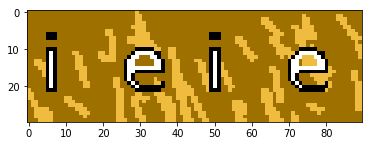

In [49]:
img = cv2.imread('./image/ieie.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 在外圍多加8格
# gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_CONSTANT)

# blur = cv2.GaussianBlur(gray, (3,3), 0)
ret, thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY)
i, contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img, contours, -1, (0,0,0), thickness= 1)    ## 畫出邊緣偵測

# for contour in contours:
#     (x, y, w, h) = cv2.boundingRect(contour)

#     cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 1)    ## 畫出框出來的矩形
plt.imshow(img)

[[70, 10, 11, 12], [49, 6, 3, 16], [26, 10, 11, 12], [5, 6, 3, 16]]


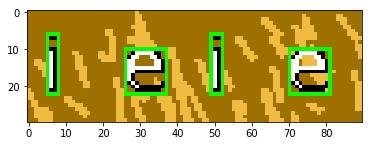

In [46]:
letter_regions = []

for contour in contours:
    (x, y, w, h) = cv2.boundingRect(contour)

#     cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 1)    ## 畫出框出來的矩形
    letter_regions.append([x, y, w, h])

new_letter = MergeContour(letter_regions, GetContoursDiff(letter_regions))
print(new_letter)

for i in new_letter:
    x,y,w,h = i
    cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 1)    ## 畫出框出來的矩形
plt.imshow(img, 'gray')

In [ ]:
# img = cv2.imread('./image/ieie.png')
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# # Add some extra padding around the image
# gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_CONSTANT)
# # blur = cv2.GaussianBlur(gray, (3,3), 0)
# ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# # i, contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# # cv2.drawContours(gray, contours, -1, (0,0,0), thickness= 1)
# # [[75, 18, 7, 16], [31, 18, 7, 16], [79, 14, 3, 2], [35, 14, 3, 2], [57, 13, 3, 17], [13, 13, 10, 17]]
# contours = [[78, 18, 11, 12], [57, 14, 3, 16], [34, 18, 11, 12], [13, 14, 3, 16]]

# for contour in contours:
# #     (x, y, w, h) = cv2.boundingRect(contour)
#     (x, y, w, h) = contour
#     print(x)
#     cv2.rectangle(gray, (x, y), (x+w, y+h), (0,255,0), 1)
#     print(w*h)
# plt.imshow(gray, 'gray')    

# GAN訓練

## 資料處理

In [ ]:
def one_hot_encoder(label, classNumber):
    onehot = []
    for i in label:
        letter = [0 for _ in range(classNumber)]
        letter[i] = 1
        onehot.append(letter)
    return np.array(onehot)

def dataProcessing(folderPath):    
    labels = []
    datas = []
    i = 0
    for labelPath in os.listdir(folderPath):
        imgPath = glob.glob(os.path.join(folderPath, labelPath)+ "/*.png")
        for path in imgPath:
            img = cv2.imread(path, 0)
            img = cv2.resize(img, (20,20), interpolation=cv2.INTER_CUBIC)
#             img = img.reshape(28,28,1)
    #         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            labels.append(i)
            datas.append(img)
        i = i+1

    labels = one_hot_encoder(np.array(labels), 26)
    
    datas = np.array(datas)
    return datas, labels

datas, labels = dataProcessing('./Extract_image/')

## Gan Training

In [ ]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import h5py
import matplotlib.pyplot as plt

import sys

import numpy as np

class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 20
        self.img_cols = 20
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 5 * 5, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((5, 5, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
#         (X_train, _), (_, _) = mnist.load_data()
#         print(X_train.shape)
#         print(X_train)
        # Rescale -1 to 1
        X_train = datas
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.generator.save("./mnist/Generate/{}.h5".format(epoch))
                self.discriminator.save("./mnist/Discriminator/{}.h5".format(epoch))
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
#         cnt = 0
#         for i in range(r):
#             for j in range(c):
#                 plt.imshow(gen_imgs[cnt, :,:,0], cmap='Greys')
#                 plt.savefig("./mnist/images/image{}.png".format(epoch))
#                 cnt += 1
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("./mnist/images/mnist_%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(epochs=50000, batch_size=32, save_interval=50)

In [ ]:
## 取得DCGAN訓練好的權重
mm = load_model('./mnist/Generate/49950.h5')
gg = load_model('./mnist/Discriminator/49950.h5')

## 將GAN產生的圖片存入資料夾內
for i in range(1000):
    noise = np.random.normal(0, 1, (1, 100))
    ab = mm.predict(noise)
    ab = 127.5 * (ab + 0.5)    ###  把原本標準化變回原圖 0~255
    bb = model.predict(ab)     ## 使用原資料訓練好的model去做預測GAN產生出來的圖形
    cc = np.argmax(bb)
    name = labelPre[cc]        ## 預測出來的類別
    pictureNumber = len(os.listdir("./Extract_image/%s/" %name))
    print(name)
    cv2.imwrite("./Extract_image/%s/%d.png" %(name, pictureNumber+1), ab[0,:,:,0])
    plt.imshow(ab[0, :,:,0], 'gray')

## 訓練驗證碼model

In [ ]:
def CNN_discriminator(num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(20, 20, 1)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(16, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(16, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.summary()
    return model

datas, labels = dataProcessing('./Extract_image/')   ### 重新取得 data & label
model = CNN_discriminator(num_classes = 26)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
dd = np.expand_dims(datas, axis=3)   ## (846,28,28) => (846,28,28,1)
history = model.fit(dd, labels,  epochs=1000, batch_size=32, shuffle=True)
model.save('testModel.h5')

## 劃出曲線圖觀測

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

In [51]:
def resize_to_fit(image, width, height):
    """
    A helper function to resize an image to fit within a given size
    :param image: image to resize
    :param width: desired width in pixels
    :param height: desired height in pixels
    :return: the resized image
    """

    # grab the dimensions of the image, then initialize
    # the padding values
    (h, w) = image.shape[:2]

    # if the width is greater than the height then resize along
    # the width
    if w > h:
        image = imutils.resize(image, width=width)

    # otherwise, the height is greater than the width so resize
    # along the height
    else:
        image = imutils.resize(image, height=height)

    # determine the padding values for the width and height to
    # obtain the target dimensions
    padW = int((width - image.shape[1]) / 2.0)
    padH = int((height - image.shape[0]) / 2.0)

    # pad the image then apply one more resizing to handle any
    # rounding issues
    image = cv2.copyMakeBorder(image, padH, padH, padW, padW,
        cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (width, height))

    # return the pre-processed image
    return image

## 測試 網頁抓取驗證碼辨識結果

In [5]:
labelPre = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f', 6:'g', 7:'h', 8:'i', 9:'j', 10:'k', 11:'l',
         12:'m', 13:'n', 14:'o', 15:'p', 16:'q', 17:'r', 18:'s', 19:'t', 20:'u', 21:'v', 22:'w', 23:'x',
         24: 'y', 25:'z'}
inputWeb = True
model = load_model('test.h5')
i = 0
verify = ""

driver = webdriver.PhantomJS()   ## 使用 PhantomJS 能將 JS動態處理的結果顯示出來
driver.get('https://nportal.ntut.edu.tw/index.do?thetime=1544083343415')   ##獲取網站原始碼
element = driver.find_element_by_id('authImage')   ## 找尋驗證碼 ID
while(inputWeb):
    img = BeautifulSoup(driver.page_source, 'xml').find(id='authImage')   ## 找尋驗證碼 html
    img_URL = "https://nportal.ntut.edu.tw/" + img['src']    ## 取得驗證碼來源
    request = requests.get(img_URL)                          ## 獲得驗證碼來源 URL
    with open('./verify/image_{}.png'.format(i), 'wb') as f: 
        f.write(request.content)                             ## 存取圖片
        
    f.close
    
    print("picture download over!")
    
    img = cv2.imread('./verify/image_{}.png'.format(i))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


    # 在外圍多加8格
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_CONSTANT)

    #     blur = cv2.GaussianBlur(gray, (3,3), 0)
    ret, thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY)
    i, contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # cv2.drawContours(img, contours, -1, (0,0,0), thickness= 1)    ## 畫出邊緣偵測

    letter_regions = []

    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)

    #     cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 1)    ## 畫出框出來的矩形
        letter_regions.append([x, y, w, h])

    new_letter = MergeContour(letter_regions, GetContoursDiff(letter_regions))    
    # if len(new_letter) != 4:
    #     break
    ## 以 x 座標做排序， 確保處理的時候是從左邊開始                    
    new_letter = sorted(new_letter, key=lambda x: x[0])
    if len(new_letter) != 4:
        continue
    
    for letter_bounding_box in new_letter:

        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = gray[y - 4: y + h + 4 ,  x - 4 :x + w + 4]
        letter_image = resize_to_fit(letter_image, 20, 20)
        letter_image = np.expand_dims(letter_image, axis=2)
        letter_image = letter_image.reshape((1,20,20,1))
        predition = model.predict(letter_image)
        index = np.argmax(predition)
        verify = verify + labelPre[index]
        print(verify)
    i += 1
    inputWeb = False
    element.click()    ## 對驗證碼做點擊動作

D:\Anaconda\envs\tensorflow\lib\site-packages\selenium\webdriver\phantomjs\webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


picture download over!
e
eq
eqt
eqtr


## 網頁自動登入

這次採用擷取整張瀏覽器圖片去尋找驗證碼位置，並將他擷取下來做後續的辨識，因為北科大網站的驗證碼是用 JS 動態生成，所以每次訪問的時候圖片會改變，導致於網頁上顯示的驗證碼，與實際辨識的驗證碼圖片是不相同的，目前是採取擷取瀏覽器圖片再去尋找驗證碼位置做剪取。<br/><br/>

**24吋螢幕:** <br/>
瀏覽器size: {'width': 945, 'height': 1020} <br/>
全圖size: (929, 889) <br/>
截圖位置： (527,237,616,266) <br/><br/>
**32吋螢幕:** <br/>
瀏覽器size: {'width': 1265, 'height': 1380} <br/>
全圖size: (1249, 1249)  <br/>
截圖位置：(687,237,776,266) <br/> <br/>
**Mac 13.5吋螢幕:**
瀏覽器size: {'width': 1050, 'height': 840}  <br/>
全圖size: (1034, 709)    <br/>
截圖位置:(579,237,668,266)   <br/>

In [53]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

# Browser = webdriver.PhantomJS()
LoginUrl= ('https://nportal.ntut.edu.tw/index.do?thetime=1521358612211')
UserName= ('yourID')
UserPass= ('yourPassword')

labelPre = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f', 6:'g', 7:'h', 8:'i', 9:'j', 10:'k', 11:'l',
         12:'m', 13:'n', 14:'o', 15:'p', 16:'q', 17:'r', 18:'s', 19:'t', 20:'u', 21:'v', 22:'w', 23:'x',
         24: 'y', 25:'z'}
inputWeb = True                       ## 確認是否進入網站
model = load_model('testModel.h5')    ## 導入模型


# Browser = webdriver.PhantomJS()
Browser = webdriver.Chrome()
Browser.get(LoginUrl)   ##獲取網站原始碼
while(inputWeb):
    verify = ""           ## 驗證碼存取變數
    
    screen_shot_data = Browser.get_screenshot_as_png()            ### 擷取瀏覽器圖片 (內容為 Bytes)
    screen_shot_data = Image.open(io.BytesIO(screen_shot_data))   ## 利用 PIL 來讀取
    img = screen_shot_data.crop((527,237,616,266))                ## 尋找驗證碼位置後，將他剪取下來
    img = img.convert('RGB')                                      ## 轉為RGB型式
    img = np.array(img)                                           ## 轉為 Array
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)                  ## 就能使用 OpenCV Library 來做操作了


    # 在外圍多加8格
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_CONSTANT)

    #     blur = cv2.GaussianBlur(gray, (3,3), 0)            ## 高斯濾波器
    ret, thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY)
    i, contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # cv2.drawContours(img, contours, -1, (0,0,0), thickness= 1)    ## 畫出邊緣偵測

    letter_regions = []

    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)

    #     cv2.rectangle(img, (x, y), (x+w, y+h), (0,255,0), 1)    ## 畫出框出來的矩形
        letter_regions.append([x, y, w, h])
    
    ## 對於 i，j 上面點點做合併動作
    new_letter = MergeContour(letter_regions, GetContoursDiff(letter_regions))    

    
    ## 以 x 座標做排序， 確保處理的時候是從左邊開始                    
    new_letter = sorted(new_letter, key=lambda x: x[0])
    if len(new_letter) != 4:
        continue
    
    ##  找尋每個字母位置並做預測
    for letter_bounding_box in new_letter:

        x, y, w, h = letter_bounding_box

        # Extract the letter from the original image with a 2-pixel margin around the edge
        letter_image = gray[y - 4: y + h + 4 ,  x - 4 :x + w + 4]
        letter_image = resize_to_fit(letter_image, 20, 20)
        letter_image = np.expand_dims(letter_image, axis=2)
        letter_image = letter_image.reshape((1,20,20,1))     ## 將圖片 reshape 為 Model 輸入型式
        predition = model.predict(letter_image)              ## model 預測
        index = np.argmax(predition)
        verify = verify + labelPre[index]
        print(verify)
        
    
    Browser.find_element_by_id('muid').send_keys(UserName)        ## 輸入帳號
    Browser.find_element_by_id('mpassword').send_keys(UserPass)   ## 輸入密碼
    Browser.find_element_by_id('authcode').send_keys(verify)      ## 輸入驗證碼
    time.sleep(5)
    Browser.find_element_by_css_selector("input[value='登入 Login']").click()    ## 案下登入
    
    try:
        check = Browser.find_element_by_css_selector("input[value='重新登入']")
        if(inputWeb == True):
            check.click()    ## 點擊重新登入
    except:
        check = None
        pass
    if check != None:
        inputWeb = True
    else:
        inputWeb = False


m
mm
mmv
mmva
